# Criação de Modelo - Import bibliotecas

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from os import listdir
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data.sampler import RandomSampler
from monai.transforms import Compose, RandRotate90, ToTensor, RandZoom, apply_transform, RandAxisFlip, RandFlip

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.models import get_model

In [4]:
path_raw = '../data/raw'
path_data = '../data/processed/train-jpegs'
path_train = '../data/processed'
path_model = '../models/best_model.pth'
path_history = '../models/history.csv'

target_name = 'result_pe'

In [5]:
df = pd.read_csv(path_train+ '/train_apply.csv')
df = df[:1000]

In [6]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [7]:
torch.cuda.set_per_process_memory_fraction(1.0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce MX150
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Dataset Pytorch

In [9]:
train_transform = Compose([RandFlip(prob = 0.2), RandZoom(prob = 0.2), ToTensor() ])

In [10]:
row = df.iloc[0]

path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID']
imgs_array = sorted([ path_img + '/' + img_path for img_path in listdir(path_img) ])

imgs_input = np.stack([ np.asarray(cv2.imread(img)).astype(np.float32) for img in imgs_array ]).transpose(3,0,1,2)

In [11]:
path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID'] + '.npz'

In [12]:
imgs_input = np.load(path_img)['arr_0']

In [13]:
imgs_input.shape

(3, 32, 112, 112)

In [14]:
def plot_scans(scans, rows = 2, cols = 6 ):
    
    fig,ax = plt.subplots(rows,cols,figsize=[20,6])
    index = 0
    
    for i in range(rows):
        for j in range(cols):
        
            scan = scans[:, index, : , :].transpose(1,2,0)
            ax[i, j].set_title(f'Scan {index+1}')
            ax[i, j].imshow( scan, cmap='bone')
            ax[i, j].axis('off')
            index += 1
            
    plt.show()

In [15]:
scan = imgs_input[: , 20:32 , : , :]

Imagem sem utiliazr técnicas de augmentations

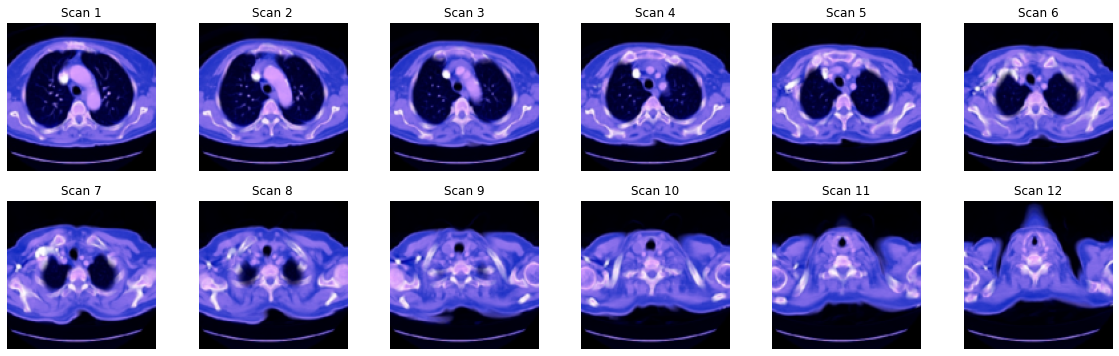

In [16]:
plot_scans(scan)

In [17]:
train_compare = Compose([RandFlip( prob = 1.0),
                         RandZoom(prob = 1.0, max_zoom= 1.2, min_zoom= 1.2),
                         ToTensor()
                         ])

Transformação da imagem caso ocorra:

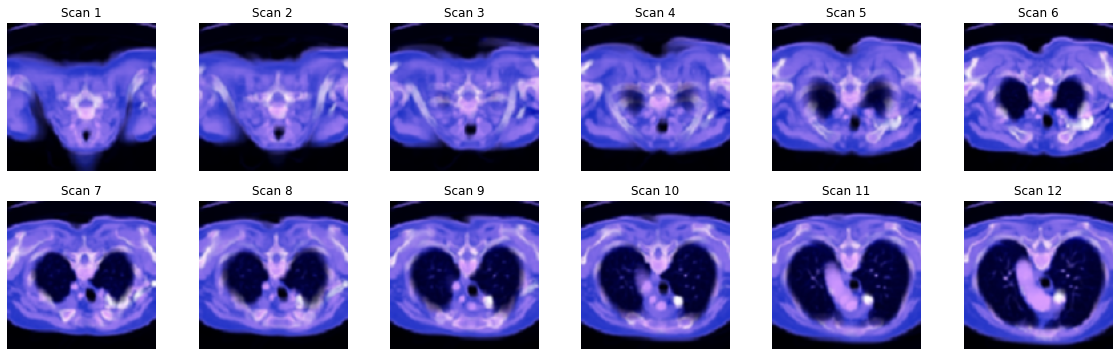

In [18]:
scan_compare = train_compare(scan)

plot_scans(scan_compare.numpy())

# Gerando dataset

In [19]:
class PEDataset(Dataset):
   
    def __init__(self, df, transform=None):
        
        self.transform = transform
        self.df = df
        
        tr = pd.read_csv(path_train+'/train_apply.csv')
    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, index):
        
        row = self.df.iloc[index]
        
        path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID'] + '.npz'
        imgs_input = np.load(path_img)['arr_0']
    
        if self.transform is not None:
            imgs_input = apply_transform(self.transform, imgs_input)
        
        return imgs_input, torch.tensor(row[target_name]).float()
        

In [20]:
dataset = PEDataset(df, train_transform)

In [21]:
data, target = dataset[0]

In [22]:
print(data.dtype)

torch.float32


In [23]:
print(data.shape, target.shape)

torch.Size([3, 32, 112, 112]) torch.Size([])


Função classificadora

In [24]:
bce = nn.BCEWithLogitsLoss()

def binary_cross_entropy(logits, target): 
    
    y_pred = logits.view(-1)
    y_target = target.view(-1)
    
    loss = bce(y_pred, y_target)
    return loss


# Gerando rede neural

In [25]:
def make_shufflenetV2():
    model = get_model(num_classes=1, sample_size=112, width_mult=1.)
    
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features= 1024, out_features = 1, bias = True),
        nn.Sigmoid()
    )
        
    return model.to(device)

In [26]:
model = make_shufflenetV2()

In [27]:
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): InvertedResidual(
      (banch1): Sequential(
        (0): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv3d(24, 58, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (3): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (banch2): Sequential(
        (0): Conv3d(24, 58, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(58, eps=1e-05, momentum=0.

In [28]:
optimizer = optim.Adam(model.parameters())

In [29]:
def acc_conf_matrix(y_pred, y_target):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
        
        if y_target[i] == 1 and y_pred[i] >= 0.5:
            TP += 1
            continue
        if y_target[i] == 1 and y_pred[i] < 0.5:
            FP += 1
            continue
        if y_target[i] == 0 and y_pred[i] < 0.5:
            TN += 1
            continue
        if y_target[i] == 0 and y_pred[i] >= 0.5:
            FN += 1
        
    
    return (TP+TN)/(len(y_pred)) , [TP,FP, TN, FN]
        

In [30]:
def train_epoch(model, train_loader, optimizer):
    
    model.train()
    train_loss = []
    y_train = []
    y_target = []
    i = 0
    
    for (data, target) in train_loader:
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        y_pred = model(data)       
        
        loss = binary_cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()

        train_loss = np.append( train_loss, loss.detach().cpu().numpy() )
        y_train = np.append( y_train, y_pred.detach().cpu())
        y_target = np.append( y_target, target.detach().cpu())
        
    acc, _ = acc_conf_matrix(y_train, y_target)
    
    
    return train_loss, acc

In [31]:
# train_epoch(model, train_loader, optimizer)

In [32]:
def val_epoch(model, train_loader):
    
    val_loss = []
    y_val = []
    y_target = []
    
    i = 0
    
    for (data, target) in train_loader:

        data, target = data.to(device), target.to(device)

        y_pred = model(data)       

        loss = binary_cross_entropy(y_pred, target)

        val_loss = np.append(val_loss, loss.detach().cpu().numpy() )
        y_val = np.append(y_val, y_pred.detach().cpu())
        y_target = np.append(y_target, target.detach().cpu())
            
    acc, conf_matrix = acc_conf_matrix(y_val, y_target)
    
    return val_loss, acc, conf_matrix


In [33]:
# val_epoch(model, train_loader)

In [34]:
def load_model():
    
    try:
        df_model = pd.read_csv('../models/aa.csv')
        last_epoch = df_model['epoch'].iloc[-1]
    except:
        df_model = pd.DataFrame(columns=['epoch', 'acc_train', 'acc_val', 'train_loss', 'val_loss', 'TP', 'TN', 'FP', 'FN'])
        return df_model, model, 0
    
    model_load = torch.load(path_model)
    return df_model, model_load, last_epoch
    

In [35]:
def train_model():
    
    msk = np.random.rand(len(df)) < 0.8
    pd_history, model, last_epoch = load_model()
    
    df_train = df[msk]
    df_val = df[~msk]
    
    dataset_train = PEDataset(df_train,  train_transform)
    dataset_val = PEDataset(df_val)
    
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = 8, sampler=RandomSampler(dataset_train))
    val_loader = torch.utils.data.DataLoader(dataset_val, batch_size = 8, sampler=RandomSampler(dataset_val))
    
    num_epochs = 1
    val_best = 10e5
    save_history = 0
    
    print('init train shape', df_train.shape, 'val shape', df_val.shape)
    
    for epoch in range(last_epoch, num_epochs):
        
        train_loss, acc_train = train_epoch(model, train_loader, optimizer)
        val_loss,  acc_val, conf_matrix = val_epoch(model, val_loader)
        
        train_loss  = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        
        pd_history = pd_history.append({
            'epoch': epoch+1, 
            'acc_train': acc_train, 
            'acc_val': acc_val, 
            'train_loss': train_loss,
            'val_loss': val_loss, 
            'TP':conf_matrix[0], 
            'TN':conf_matrix[2], 
            'FP':conf_matrix[1], 
            'FN':conf_matrix[3],
        }, ignore_index=True)

        pd_history.to_csv(path_history, index=False)
        
        if val_loss < val_best:

            val_best = np.mean(val_loss) 
            torch.save(model.state_dict(), path_model)

        print('epoch =', epoch+1, ' acc_train =', acc_train, ' acc_val =', acc_val)
        

In [36]:
%%time

train_model()

init train shape (795, 5) val shape (205, 5)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 1.96 GiB total capacity; 789.55 MiB already allocated; 26.50 MiB free; 1.96 GiB allowed; 810.00 MiB reserved in total by PyTorch)

In [37]:
pd.read_csv(path_history)

,epoch,acc_train,acc_val,train_loss,val_loss,TP,TN,FP,FN
0,1.0,0.771084,0.588235,0.69278,0.693313,0.0,10.0,7.0,0.0
